In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Load ultimate_data_challenge.json as DataFrame
with open('ultimate_data_challenge.json') as datafile:
    data = json.load(datafile)
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [2]:
# Drop rows with null values
df.dropna(inplace=True)

# Show the first 5 rows
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
def city_num(x):
    if x == "King's Landing":
        x = 1
    elif x == "Astapor":
        x = 2
    else:
        x = 3
    return x

df['city_num'] = df['city'].apply(city_num)

# Change data types for "signup_date" and "last_trip_date" columns to DateTime values
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

# Use index as UserID as unique identifier
df = df.reset_index()

# Create new column to define if a user is "active" (i.e. 1 for "last_trip_date" within 
# the last 30 days of last date, 0 otherwise)
df['IsActiveUser'] = df.last_trip_date.apply(lambda x: 1 if x > datetime.datetime(2014,6,1) else 0)

# Create new column to convert "phone" column to boolean (i.e. 1 for iPhone, 0 for Android)
df['phone_bool'] = df.phone.apply(lambda x: 1 if x == "iPhone" else 0)

df

,index,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_num,IsActiveUser,phone_bool
0,0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1,1
1,1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2,0,0
2,2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2,0,1
3,3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1,1
4,4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41440,49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,2,1,1
41441,49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,2,0,1
41442,49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1,1,1
41443,49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,3,0,0


C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


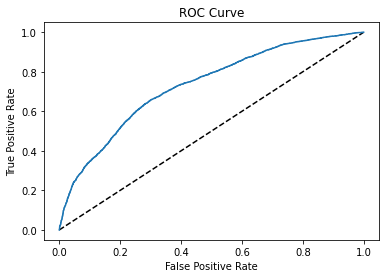

In [4]:
# Define X and y data sets
X = df[['city_num', 'trips_in_first_30_days','avg_rating_of_driver',
       'avg_surge', 'phone_bool', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'phone_bool']]

y = df['IsActiveUser']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression(solver='lbfgs')
    
# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [5]:
print(confusion_matrix(y_test, y_pred))

[[6129 1298]
 [2659 2348]]


In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      7427
           1       0.64      0.47      0.54      5007

    accuracy                           0.68     12434
   macro avg       0.67      0.65      0.65     12434
weighted avg       0.68      0.68      0.67     12434

